#libs

In [ ]:
!pip install numpy==1.25.2
!pip install pandas
!pip install torch==2.5.0
!pip install lightfm

ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/install.py", line 377, in run
    requirement_set = resolver.resolve(
                      ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/resolution/resolvelib/resolver.py", line 95, in resolve
    result = self._result = resolver.resolve(
                            ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_vendor/resolvelib/resolvers.py", line 546, in resolve
    state = resolution.resolve(requirements, max_rounds=max_rounds)
            

# import libs

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon May 26 08:42:45 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   47C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import torch
if torch.cuda.is_available():
    print("CUDA is available. Using GPU.")
    device = torch.device("cuda")
else:
    print("CUDA is not available. Using CPU.")
    device = torch.device("cpu")

CUDA is available. Using GPU.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity


# mount drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
file_path = '/content/drive/MyDrive/Master Thesis/renttherunway_final_data.json' # insert file path here
df_rent = pd.read_json(file_path, lines=True)

# Print stat dataset


In [6]:
def print_stats(df, name):
    print(f"\n--- {name} ---")
    print("Shape:", df.shape)
    print("Missing values:\n", df.isna().sum())
    print("Duplicates:", df.duplicated().sum())
    print(df.describe(include="all"))
    stats = {}
    stats["Dataset"] = name
    stats["Number of users"] = df["user_id"].nunique()
    stats["Number of items"] = df["item_id"].nunique()
    stats["Total interactions"] = len(df)
    stats["Average interactions per user"] = df.groupby("user_id").size().mean()
    user_item_matrix = df.pivot_table(index='user_id', columns='item_id', aggfunc='size', fill_value=0)
    sparsity = 1 - np.count_nonzero(user_item_matrix.values) / float(user_item_matrix.size)
    stats["Sparsity of user-item matrix"] = sparsity

    stats["Number of unique items per user"] = df.groupby('user_id')['item_id'].nunique().mean()
    stats["Number of unique users per item"] = df.groupby('item_id')['user_id'].nunique().mean()

    if "rating" in df.columns:
        stats["Median rating"] = df["rating"].median()
        stats["Rating std"] = df["rating"].std()
    print(stats)

print(print_stats(df_rent, "Renttherunway"))
print(df_rent.describe(include='all'))



--- Renttherunway ---
Shape: (192544, 15)
Missing values:
 fit                   0
user_id               0
bust size         18411
item_id               0
weight            29982
rating               82
rented for           10
review_text           0
body type         14637
review_summary        0
category              0
height              677
size                  0
age                 960
review_date           0
dtype: int64
Duplicates: 189
           fit        user_id bust size       item_id  weight         rating  \
count   192544  192544.000000    174133  1.925440e+05  162562  192462.000000   
unique       3            NaN       106           NaN     190            NaN   
top        fit            NaN       34b           NaN  130lbs            NaN   
freq    142058            NaN     27285           NaN   14370            NaN   
mean       NaN  499494.100149       NaN  1.045684e+06     NaN       9.092371   
std        NaN  289059.719328       NaN  8.053148e+05     NaN       1.4

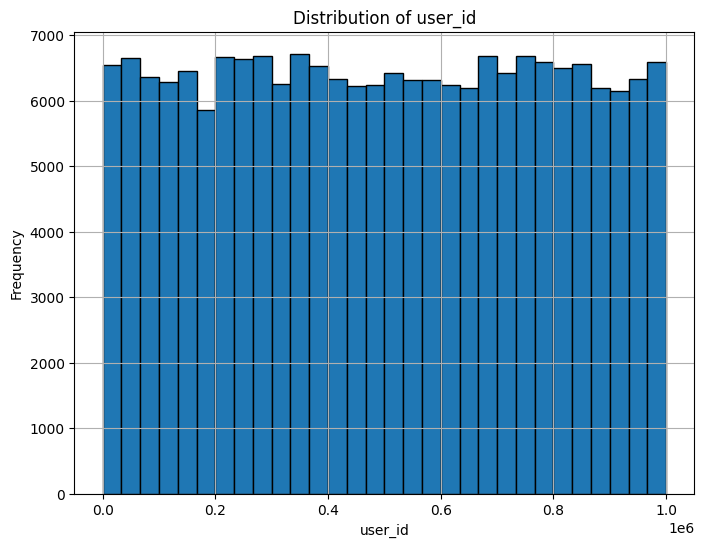


--- Distribution of user_id ---
count    192544.000000
mean     499494.100149
std      289059.719328
min           9.000000
25%      250654.250000
50%      499419.000000
75%      750974.000000
max      999997.000000
Name: user_id, dtype: float64


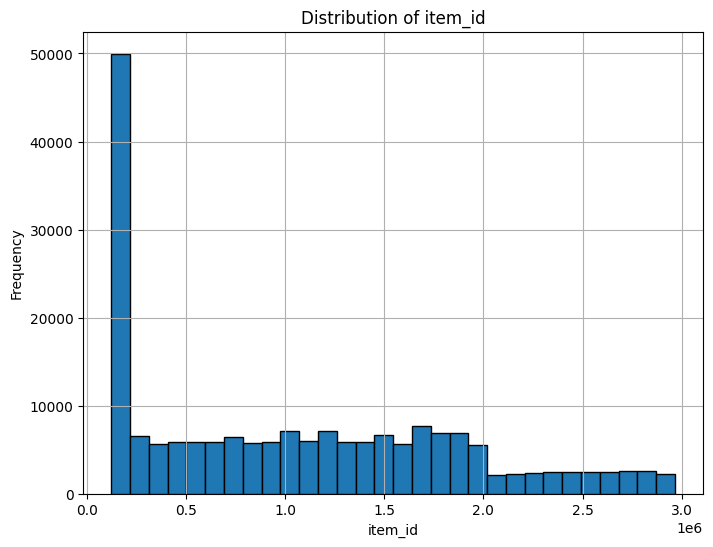


--- Distribution of item_id ---
count    1.925440e+05
mean     1.045684e+06
std      8.053148e+05
min      1.233730e+05
25%      1.950760e+05
50%      9.483960e+05
75%      1.678888e+06
max      2.966087e+06
Name: item_id, dtype: float64


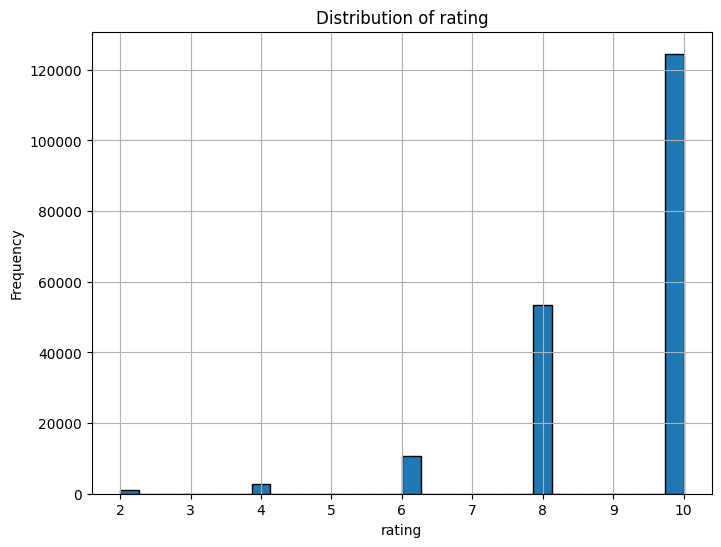


--- Distribution of rating ---
count    192462.000000
mean          9.092371
std           1.430044
min           2.000000
25%           8.000000
50%          10.000000
75%          10.000000
max          10.000000
Name: rating, dtype: float64


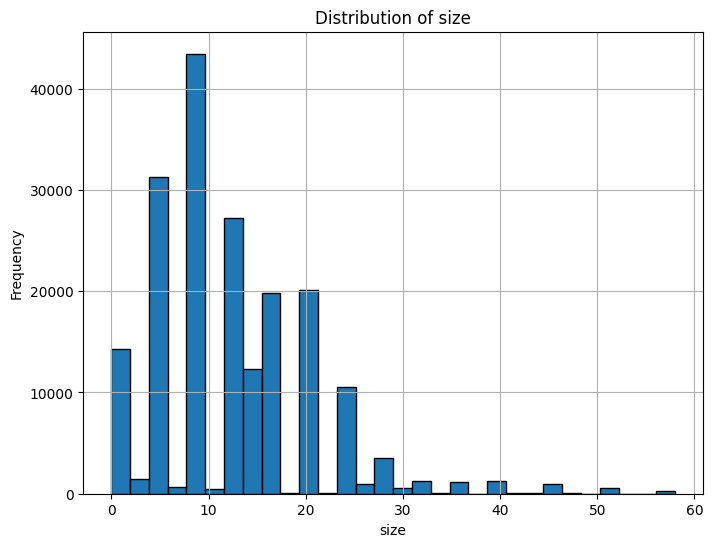


--- Distribution of size ---
count    192544.000000
mean         12.245175
std           8.494877
min           0.000000
25%           8.000000
50%          12.000000
75%          16.000000
max          58.000000
Name: size, dtype: float64


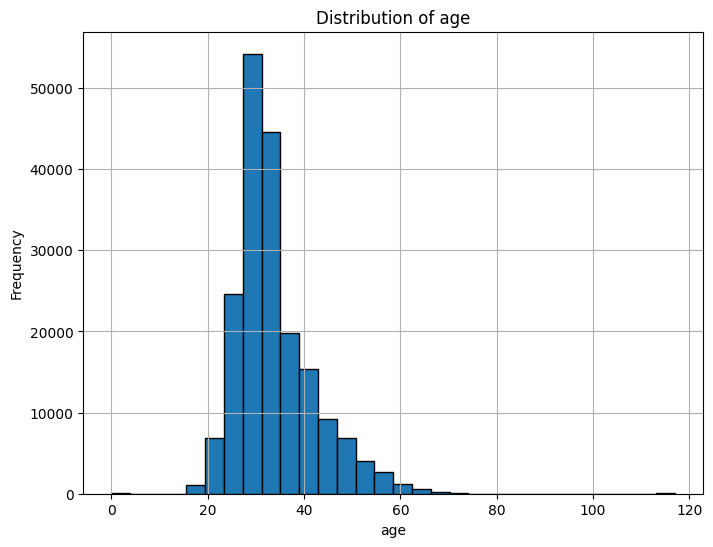


--- Distribution of age ---
count    191584.000000
mean         33.871017
std           8.058083
min           0.000000
25%          29.000000
50%          32.000000
75%          37.000000
max         117.000000
Name: age, dtype: float64


In [7]:
def plot_feature_distributions(df):
    """Plots the distribution of each numerical feature in the DataFrame."""
    numerical_features = df.select_dtypes(include=np.number).columns

    for feature in numerical_features:
        plt.figure(figsize=(8, 6))
        plt.hist(df[feature].dropna(), bins=30, edgecolor='k')
        plt.title(f'Distribution of {feature}')
        plt.xlabel(feature)
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.show()

        print(f"\n--- Distribution of {feature} ---")
        print(df[feature].describe())

plot_feature_distributions(df_rent)

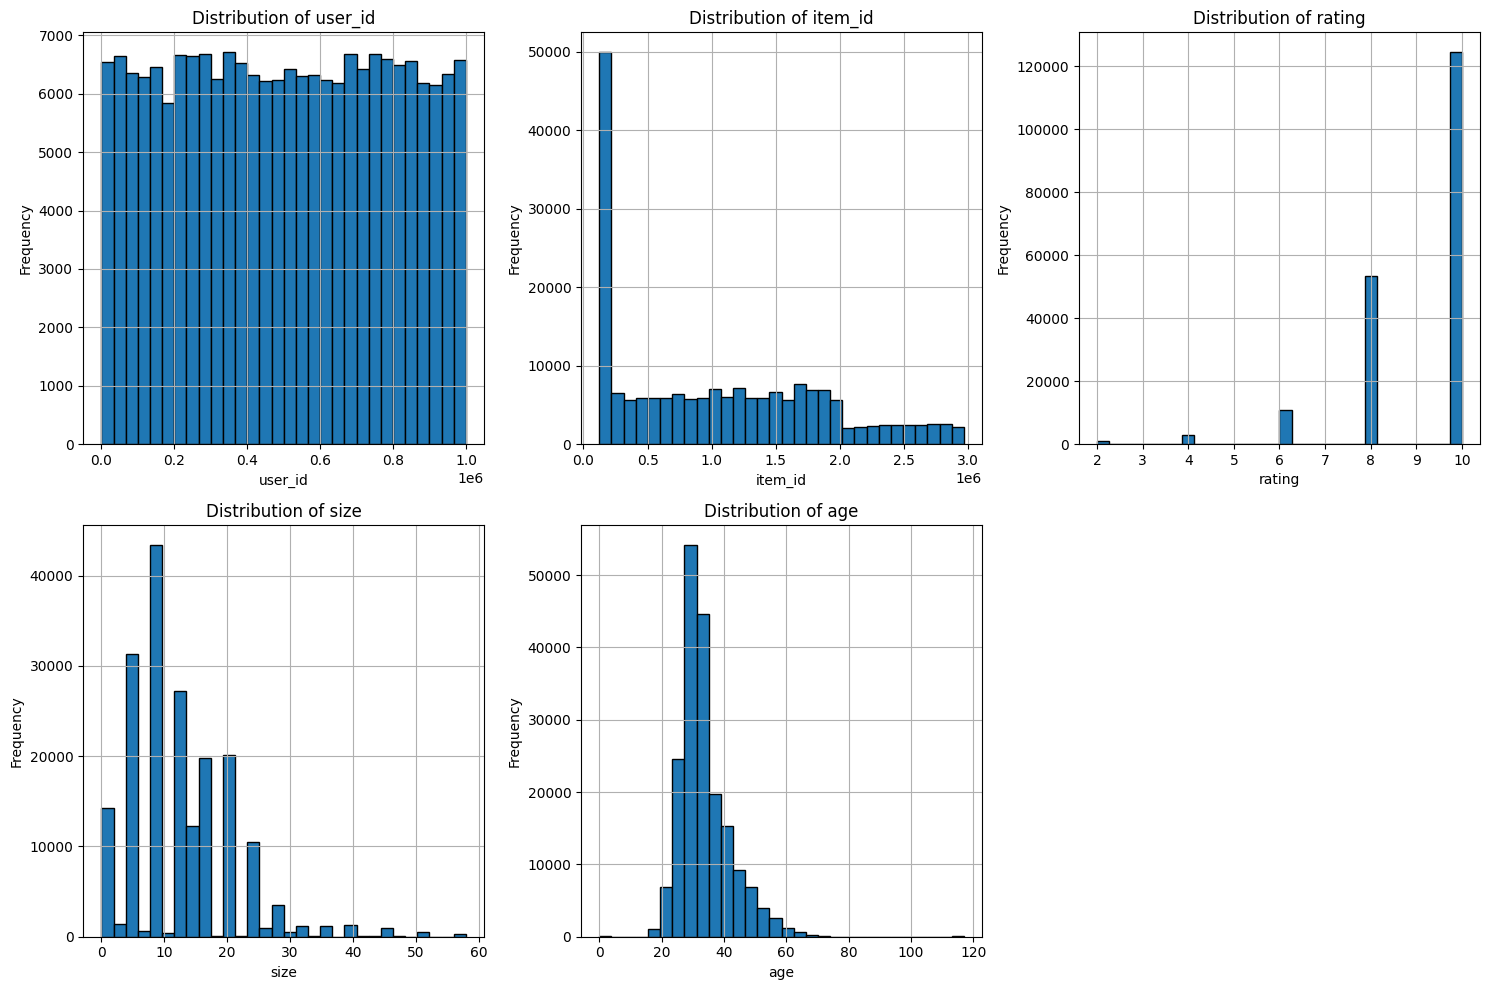

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def plot_feature_distributions_matrix(df):
    """Plots the distribution of each numerical feature in a matrix layout."""
    numerical_features = df.select_dtypes(include=np.number).columns
    num_features = len(numerical_features)


    num_cols = int(np.ceil(np.sqrt(num_features)))
    num_rows = int(np.ceil(num_features / num_cols))

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))
    axes = axes.flatten()


    for i, feature in enumerate(numerical_features):
        ax = axes[i]
        ax.hist(df[feature].dropna(), bins=30, edgecolor='k')
        ax.set_title(f'Distribution of {feature}')
        ax.set_xlabel(feature)
        ax.set_ylabel('Frequency')
        ax.grid(True)

    for i in range(num_features, num_rows * num_cols):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()


plot_feature_distributions_matrix(df_rent)

# Preprocessing

In [9]:

df_rent_clean = df_rent.dropna(subset=["user_id", "item_id", "rating","age"]).drop_duplicates()

In [10]:
###############################################
# 3. Explicit Feedback
###############################################

df_rent_clean['interaction'] = df_rent_clean['rating']

In [11]:
df_rent.head()

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
0,fit,420272,34d,2260466,137lbs,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,"5' 8""",14,28.0,"April 20, 2016"
1,fit,273551,34b,153475,132lbs,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,"5' 6""",12,36.0,"June 18, 2013"
2,fit,360448,NaN,1063761,NaN,10.0,party,This hugged in all the right places! It was a ...,NaN,It was a great time to celebrate the (almost) ...,sheath,"5' 4""",4,116.0,"December 14, 2015"
3,fit,909926,34c,126335,135lbs,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,"5' 5""",8,34.0,"February 12, 2014"
4,fit,151944,34b,616682,145lbs,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,"5' 9""",12,27.0,"September 26, 2016"


In [12]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
category_bow = vectorizer.fit_transform(df_rent_clean['category'])

# Sparsity

In [13]:
def calculate_sparsity(df):
    """Calculates sparsity for each numerical feature in the DataFrame."""
    numerical_features = df.select_dtypes(include=np.number).columns
    sparsity_results = {}

    for feature in numerical_features:
        sparsity = df[feature].isnull().sum() / len(df)
        sparsity_results[feature] = sparsity

    return sparsity_results

sparsity_dict = calculate_sparsity(df_rent_clean)
print(sparsity_dict)

{'user_id': np.float64(0.0), 'item_id': np.float64(0.0), 'rating': np.float64(0.0), 'size': np.float64(0.0), 'age': np.float64(0.0), 'interaction': np.float64(0.0)}


In [14]:
def preprocess_data(df, sparsity_threshold=0.50):
    """Preprocesses the data by removing numerical features with high sparsity."""
    for col in df.select_dtypes(include=np.number).columns:
        sparsity = df[col].isnull().sum() / len(df)
        if sparsity > sparsity_threshold:
            print(f"Dropping sparse feature: {col} (Sparsity: {sparsity:.2f})")
            df = df.drop(col, axis=1)
    return df

# more equal than 2 interactions

In [15]:
df_rent_clean = preprocess_data(df_rent_clean, sparsity_threshold=0.50)

user_interaction_counts = df_rent_clean.groupby('user_id')['rating'].count()
users_with_enough_interactions = user_interaction_counts[user_interaction_counts >= 2].index
df_rent_clean = df_rent_clean[df_rent_clean["user_id"].isin(users_with_enough_interactions)]
print(f"Number of users with more than 2 interactions: {len(users_with_enough_interactions)}")

Number of users with more than 2 interactions: 33544



--- Distribution of age ---
count    119986.000000
mean         34.261405
std           7.859713
min           0.000000
25%          29.000000
50%          32.000000
75%          38.000000
max         117.000000
Name: age, dtype: float64

--- Distribution of rating ---
count    119986.000000
mean          9.028070
std           1.474393
min           2.000000
25%           8.000000
50%          10.000000
75%          10.000000
max          10.000000
Name: rating, dtype: float64


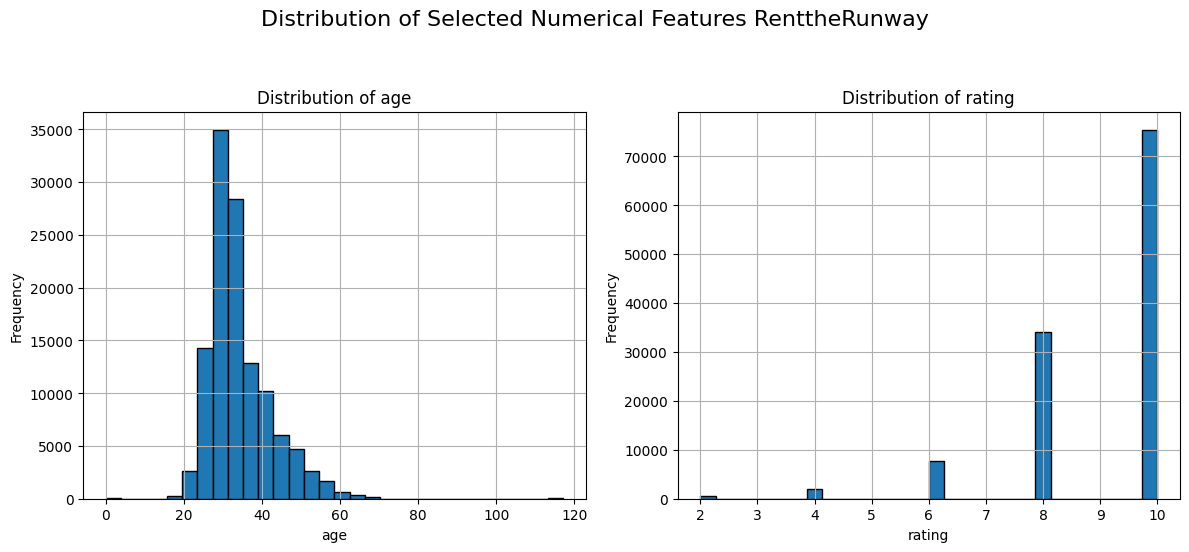

In [16]:
import numpy as np
import matplotlib.pyplot as plt

def plot_selected_feature_distributions_matrix_with_caption(df, features_to_plot):
    """
    Plots the distribution of selected numerical features in a 2x2 matrix with a caption.

    Args:
        df: The DataFrame containing the data.
        features_to_plot: A list of numerical feature names to plot.
                          Should contain at most 4 feature names for a 2x2 matrix.
    """
    if len(features_to_plot) > 4:
        print("Warning: More than 4 features provided. Plotting only the first 4.")
        features_to_plot = features_to_plot[:4]

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    axes = axes.flatten()


    for i, feature in enumerate(features_to_plot):
        if feature in df.columns and np.issubdtype(df[feature].dtype, np.number):
            axes[i].hist(df[feature].dropna(), bins=30, edgecolor='k')
            axes[i].set_title(f'Distribution of {feature}')
            axes[i].set_xlabel(feature)
            axes[i].set_ylabel('Frequency')
            axes[i].grid(True)

            print(f"\n--- Distribution of {feature} ---")
            print(df[feature].describe())
        else:
            print(f"Warning: Feature '{feature}' not found or not numerical. Skipping.")
            fig.delaxes(axes[i])

    for j in range(len(features_to_plot), len(axes)):
        fig.delaxes(axes[j])


    fig.suptitle('Distribution of Selected Numerical Features RenttheRunway', fontsize=16)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

features_to_visualize = [ 'age',  'rating']

plot_selected_feature_distributions_matrix_with_caption(df_rent_clean, features_to_visualize)

# plot user activity

In [17]:
user_activity = df_rent_clean.groupby('user_id')['interaction'].sum()

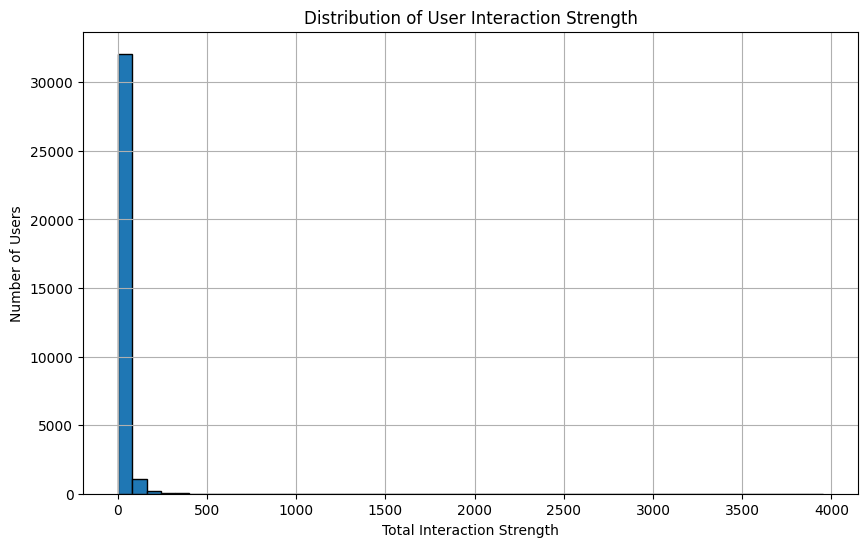


--- Renttherunway (After Cleaning) ---
Shape: (119986, 16)
Missing values:
 fit                   0
user_id               0
bust size         10024
item_id               0
weight            16369
rating                0
rented for            7
review_text           0
body type          7272
review_summary        0
category              0
height              322
size                  0
age                   0
review_date           0
interaction           0
dtype: int64
Duplicates: 0
           fit        user_id bust size       item_id  weight         rating  \
count   119986  119986.000000    109962  1.199860e+05  103617  119986.000000   
unique       3            NaN        94           NaN     163            NaN   
top        fit            NaN       34b           NaN  130lbs            NaN   
freq     87285            NaN     17562           NaN    9210            NaN   
mean       NaN  498527.586793       NaN  1.178068e+06     NaN       9.028070   
std        NaN  289176.383442   

In [18]:
plt.figure(figsize=(10, 6))
plt.hist(user_activity, bins=50, edgecolor='k')
plt.title('Distribution of User Interaction Strength')
plt.xlabel('Total Interaction Strength')
plt.ylabel('Number of Users')
plt.grid(True)
plt.show()

print(print_stats(df_rent_clean, "Renttherunway (After Cleaning)"))

# divide into user groups

In [19]:
median_interaction_strength = df_rent_clean.groupby('user_id')['interaction'].sum().median()

df_rent_clean['user_activity'] = df_rent_clean.groupby('user_id')['interaction'].transform('sum').map(
    lambda x: 'Low' if x < median_interaction_strength else 'High'
)

print(df_rent_clean['user_activity'].value_counts())

user_activity
High    99471
Low     20515
Name: count, dtype: int64


In [20]:
user_interactions = df_rent_clean.groupby('user_id').size()
print(user_interactions)

user_id
9         2
35        2
47        5
207       2
224       2
         ..
999954    2
999969    3
999971    2
999987    2
999997    2
Length: 33544, dtype: int64


In [21]:
user_activity_counts = df_rent_clean.groupby('user_activity')['user_id'].nunique()

print("Number of unique users in each activity group:")
print(user_activity_counts)

Number of unique users in each activity group:
user_activity
High    23340
Low     10204
Name: user_id, dtype: int64


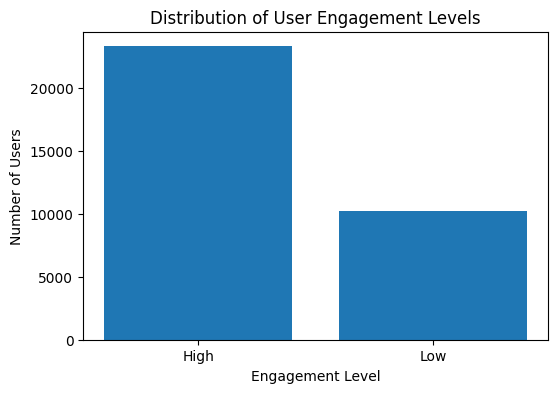

In [22]:

# --USER ENGAGEMENT PLOT
plt.figure(figsize=(6, 4))
plt.bar(user_activity_counts.index, user_activity_counts.values)
plt.xlabel("Engagement Level")
plt.ylabel("Number of Users")
plt.title("Distribution of User Engagement Levels")
plt.show()


# Samples FOR TESTING ONLY

In [ ]:
######### FOR TESTING ONLY #########
df_rent_clean = df_rent_clean.sample(frac=0.2, random_state=42)

# Train Test Set

In [ ]:

df_rent_clean = df_rent_clean.sort_values('review_date')

train_size = int(0.6 * len(df_rent_clean))
val_size = int(0.2 * len(df_rent_clean))

train_df = df_rent_clean[:train_size]
val_df = df_rent_clean[train_size:train_size + val_size]
test_df = df_rent_clean[train_size + val_size:]

print("Train set shape:", train_df.shape)
print("Validation set shape:", val_df.shape)
print("Test set shape:", test_df.shape)


Train set shape: (71991, 17)
Validation set shape: (23997, 17)
Test set shape: (23998, 17)


# User Item Matrix

In [ ]:
###############################################
# 3. User Item Matrix -Train
###############################################
train_user_item_matrix = train_df.pivot_table(
    index="user_id",
    columns="item_id",
    values="interaction",
    aggfunc="sum",
    fill_value=0
)


#Nearest Neighbours

## Hyperparameter

In [ ]:
!pip install tensorflow

Best hyperparameters: {'algorithm': 'auto', 'k': 15, 'metric': 'euclidean', 'n_neighbors': 5}

In [ ]:
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import precision_score

best_params = None
best_precision = 0

# Create user-item matrices for training and validation
train_user_item_matrix = train_df.pivot_table(index="user_id", columns="item_id", values="interaction", aggfunc="sum", fill_value=0)
val_user_item_matrix = val_df.pivot_table(index="user_id", columns="item_id", values="interaction", aggfunc="sum", fill_value=0)

# Align the columns of the validation matrix with the training matrix
val_user_item_matrix = val_user_item_matrix.reindex(columns=train_user_item_matrix.columns, fill_value=0)

def evaluate_model(model, train_data, val_data, k=5):
        """Evaluates the model using precision@k on the validation set."""

        # Get the top-k recommendations for each user in the validation set
        distances, indices = model.kneighbors(val_data, n_neighbors=k)

        precisions = []

        for i in range(len(val_data)):
            # Get the items the user has interacted with in the validation set
            actual_items = val_data.iloc[i][val_data.iloc[i] > 0].index.tolist() # Get items with interaction strength > 0

            # Get the indices of the recommended items from the training set
            predicted_items = [train_data.columns[j] for j in indices[i] if j < len(train_data.columns)]

            # Calculate the number of relevant recommendations (items in both actual and predicted)
            num_relevant_recommendations = len(set(actual_items) & set(predicted_items))

            # Calculate precision@k for this user (handle zero division)
            precision = num_relevant_recommendations / k if k > 0 else 0
            precisions.append(precision)

        # Return the average precision@k over all users
        return np.mean(precisions)

# Define the parameter grid with valid metric-algorithm combinations
param_grid = {
        'n_neighbors': [5, 10, 15, 20],  # Explore different values for k
        'algorithm': ['auto', 'ball_tree',  'brute'],
        'metric': ['cosine', 'euclidean'],
        'k': [5, 10, 15] # Include k for evaluation
}

# Filter out invalid combinations
filtered_param_grid = []
for params in ParameterGrid(param_grid):
    if params['algorithm'] == 'ball_tree' and params['metric'] == 'cosine':
        continue  # Skip this invalid combination
    else:
        filtered_param_grid.append(params)


for params in filtered_param_grid: # Use the filtered grid
        model = NearestNeighbors(n_neighbors=params['n_neighbors'], algorithm=params['algorithm'], metric=params['metric'])
        model.fit(train_user_item_matrix)
        precision = evaluate_model(model, train_user_item_matrix, val_user_item_matrix, k=params['k'])
        if precision > best_precision:
            best_precision = precision
            best_params = params

print(f"Best hyperparameters: {best_params}")
print(f"Best precision@k: {best_precision}")



Best hyperparameters: {'algorithm': 'auto', 'k': 5, 'metric': 'euclidean', 'n_neighbors': 5}
Best precision@k: 0.00044215180545320565


Best hyperparameters: {'algorithm': 'auto', 'k': 5, 'metric': 'euclidean', 'n_neighbors': 5}
Best precision@k: 0.00044215180545320565

## Model -test

In [ ]:
from cuml.neighbors import NearestNeighbors  # GPU version because otherwise it runs too long time
from cuml.metrics import pairwise_distances

In [ ]:
nn_model = NearestNeighbors(n_neighbors=5, algorithm='auto', metric='euclidean')
nn_model.fit(train_user_item_matrix)

NearestNeighbors()

In [ ]:
distances, indices = nn_model.kneighbors(train_user_item_matrix)
print("Distances shape:", distances.shape)
print("Indices shape:", indices.shape)

Distances shape: (27439, 5)
Indices shape: (27439, 5)


##NearestNeighbors

## # Recommendation User based model

In [ ]:
###############################################
# 3. Recommendation User based model
###############################################
def get_user_based_recommendations(user_index, neighbor_indices, train_matrix, distances, user_engagement_levels, low_engagement_weight=1.5, top_k=5):
    """
      generate Recommendations for a user based on preference or similar users (neighbors) using user-based CF

      Args:
        user_index: index of user in the user-item matrix
        neighbor_indices: indices of the nearest neighbors
        train_matrix: user-item matrix
        distances: distance matrix of nearest neighbors
        user_engagement_levels: dictionary mapping user IDs to engagement levels
        low_engagement_weight: weight applied to interactions of users in the "Low" engagement group
        top_k: number of recommendations to generate

      Returns:
        recommendations: list of recommended items for the user
    """

    user_interacted = train_matrix.columns[train_matrix.iloc[user_index] > 0].tolist()
    rec_scores = {}
    for i, neighbor in enumerate(neighbor_indices[:10]):
        if neighbor == user_index:
            continue
        neighbor_engagement_level = user_engagement_levels.get(train_matrix.index[neighbor])
        neighbor_vector = train_matrix.iloc[neighbor]
        for item, score in neighbor_vector.items():
            if score > 0 and item not in user_interacted:
                weight = low_engagement_weight if neighbor_engagement_level == "Low" else 1.0
                rec_scores[item] = rec_scores.get(item, 0) + (score * weight) * (1 / (1 + distances[user_index][i]))

    if not rec_scores:
        return [(item, 0) for item in np.random.choice(train_matrix.columns, size=top_k, replace=False).tolist()]

    return sorted(rec_scores.items(), key=lambda x: x[1], reverse=True)[:top_k]

In [ ]:
from scipy.sparse import csr_matrix
user_engagement_levels = df_rent_clean.set_index('user_id')['user_activity'].to_dict()
user_based_recs = {}
for i, user in enumerate(train_user_item_matrix.index):
    neighbor_indices = indices[i]
    valid_neighbor_indices = [n for n in neighbor_indices if 0 <= n < len(train_user_item_matrix.index)]
    user_based_recs[user] = get_user_based_recommendations(
        i, valid_neighbor_indices, train_user_item_matrix, distances, user_engagement_levels,
        low_engagement_weight=1.5, top_k=5
    )

# Definition ranking metrics
## ndcg_at_k, hit_rate_at_k, mrr_at_k

In [ ]:
###############################################
# 3. Utility/Ranking metrics
###############################################
def dcg_at_k_recursive(relevance_scores, k, b=2):
    """
    Calculate the Discounted Cumulative Gain at rank k recursively.

    :param relevance_scores: A list or array of relevance scores for the ranked items.
    :param k: The rank at which to stop (k items to evaluate).
    :param b: The base of the logarithm (typically 2).
    :return: DCG at rank k.
    """
    k = min(k, len(relevance_scores))
    if k == 0:
        return 0.0

    if k < b:
        return np.sum([rel / np.log2(idx + 2) for idx, rel in enumerate(relevance_scores[:k])])

    else:
        dcg_k_minus_1 = dcg_at_k_recursive(relevance_scores, k - 1, b)
        rel_k = relevance_scores[k - 1]
        return dcg_k_minus_1 + (rel_k / np.log2(k + 1))  #

def dcg_at_k(relevance_scores, k, b=2):
    """
    Calculate the Discounted Cumulative Gain at rank k (non-recursive).
    """
    dcg = 0
    for idx, rel in enumerate(relevance_scores[:k]):
        dcg += rel / np.log2(idx + 2)
    return dcg
def idcg_at_k(relevance_scores, k):
    """
    Calculate the Ideal Discounted Cumulative Gain at rank k.
    :param relevance_scores: A list or array of relevance scores for the ranked items.
    :param k: The rank at which to stop (k items to evaluate).
    :return: Ideal DCG at rank k.
    """
    relevance_scores = sorted(relevance_scores, reverse=True)
    return dcg_at_k(relevance_scores, k)

def ndcg_at_k(relevance_scores, k):
    """
    Calculate the Normalized Discounted Cumulative Gain at rank k.
    :param relevance_scores: A list or array of relevance scores for the ranked items.
    :param k: The rank at which to stop (k items to evaluate).
    :return: nDCG at rank k.
    """
    dcg = dcg_at_k_recursive(relevance_scores, k)
    idcg = idcg_at_k(relevance_scores, k)
    if idcg == 0:
        return 0
    return dcg / idcg



In [ ]:
def hr_at_k(actual, predicted, k=5):
    """
    Computes Hit Rate (HR) at rank k.

    Args:
        actual: list of relevant items
        predicted: ranked list of items
        k: rank cutoff (default is 5)

    Returns:
        Hit Rate at rank k.
    """

    for item in predicted[:k]:
        if item in actual:
            return 1
    return 0


def hit_rate_at_k(actual, predicted, k=5):
    """
    Computes Mean Hit Rate (HR) at rank k for all users.

    Args:
        actual: list of relevant items for each user
        predicted: list of predicted ranked items for each user
        k: rank cutoff (default is 5)

    Returns:
        HR at rank k.
    """

    if not actual or len(predicted) == 0:
        return 0.0


    hr_scores = []
    for user_actual, user_predicted in zip(actual, predicted):
        hr = hr_at_k(user_actual, user_predicted, k)
        hr_scores.append(hr)
    return np.mean(hr_scores)

In [ ]:
def rr_at_k(actual, predicted, k=5):
    """
    Computes Reciprocal Rank at rank k.

    Args:
        actual: the relevant item(s)
        predicted: the ranked list of items
        k: rank cutoff (default is 5)

    Returns:
        Reciprocal Rank at rank k.
    """

    for i, item in enumerate(predicted[:k]):
        if item == actual:
            return 1 / (i + 1)
    return 0.0  # 0 if the relevant item is not in the top-k


def mrr_at_k(actual, predicted, k=5):
    """
    Computes Mean Reciprocal Rank (MRR) at rank k.

    Args:
        actual: list of relevant items (can be multiple)
        predicted: ranked list of items
        k: rank cutoff (default is 5)

    Returns:
        MRR at rank k.
    """

    if actual is None or len(predicted) == 0:
        return 0.0

    rr_scores = []
    for item in actual:
        rr = rr_at_k(item, predicted, k)
        rr_scores.append(rr)

    return np.mean(rr_scores)

# DEFINITION FAIRNESS METRICS
## calculate_disparate_impact, calculate_group_recommender_unfairness, mean_absolute_difference

In [ ]:
def calculate_disparate_impact(protected_outcomes, privileged_outcomes):
    """
    Args:
        protected_outcomes: List of binary outcomes (1=favorable) for the protected group.
        privileged_outcomes: List of binary outcomes for the privileged group.
    Returns:
        Disparate impact ratio.
    """
    protected_rate = np.mean(protected_outcomes)
    privileged_rate = np.mean(privileged_outcomes)

    if privileged_rate == 0:
        return np.inf

    return protected_rate / privileged_rate

def calculate_group_recommender_unfairness(group1_metrics, group2_metrics):
  """
    Calculates the absolute difference in mean metrics between two groups.
    This metric quantifies the unfairness of a recommender system by examining
    the absolute difference in average performance between different user groups.

    Args:
        group1_metrics (list or numpy.ndarray): A list or numpy array of metrics for group 1.
        group2_metrics (list or numpy.ndarray): A list or numpy array of metrics for group 2.

    Returns:
        float: The absolute difference in mean metrics between the two groups.
  """
  return np.abs(np.mean(group1_metrics) - np.mean(group2_metrics))




In [ ]:


def coefficient_of_variation(arr):
    mean_val = np.mean(arr)
    if mean_val == 0:
        return 0
    return np.std(arr) / mean_val

def calculate_ucv(metric_low_group, metric_high_group):

    cv_low = coefficient_of_variation(metric_low_group) if len(metric_low_group) > 0 else 0
    cv_high = coefficient_of_variation(metric_high_group) if len(metric_high_group) > 0 else 0
    return (cv_low + cv_high) / 2

def coefficient_of_variance(group):
    """Calculates the coefficient of variance for a group."""
    return np.std(group) / np.mean(group) if np.mean(group) != 0 else 0

# apply ranking metrics to CF first round

In [ ]:


test_items = test_df.groupby("user_id")["item_id"].first().to_dict()
metrics_user_based = []
for user in train_user_item_matrix.index:
    actual_item = test_items.get(user, None)
    recs_tuples = user_based_recs.get(user, [])
    recs = [item for item, score in recs_tuples]
    if actual_item is None:
        continue
    relevance_scores = [1 if item == actual_item else 0 for item in recs]
    ndcg = ndcg_at_k(relevance_scores, k=5)
    hr = hr_at_k([actual_item], recs, k=5)
    mrr = mrr_at_k([actual_item], recs, k=5)
    cv= coefficient_of_variance(relevance_scores)
    metrics_user_based.append([user, ndcg, hr, mrr,cv])

metrics_user_based_df = pd.DataFrame(metrics_user_based, columns=["User", "NDCG@K", "HR@K", "MRR@K","CV"])


mean_ndcg = metrics_user_based_df["NDCG@K"].mean()
mean_hr = metrics_user_based_df["HR@K"].mean()
mean_mrr = metrics_user_based_df["MRR@K"].mean()
mean_cv = metrics_user_based_df["CV"].mean()

print(f"Mean NDCG@K: {mean_ndcg}")
print(f"Mean HR@K: {mean_hr}")
print(f"Mean MRR@K: {mean_mrr}")
print(f"Mean CV: {mean_cv}")

In [ ]:
metrics_per_group = {"Low": [], "Moderate/High": []}
for i, user in enumerate(train_user_item_matrix.index):
    actual_item = test_items.get(user, None)
    recs_tuples = user_based_recs.get(user, [])
    recs = [item for item, score in recs_tuples]
    if actual_item is None:
        continue
    engagement_level = df_rent_clean[df_rent_clean['user_id'] == user]['user_activity'].values[0]
    if engagement_level == "Low":
        relevance_scores = [1 if item == actual_item else 0 for item in recs]
        ndcg = ndcg_at_k(relevance_scores, k=6)
        hr_val = hr_at_k([actual_item], recs, k=6)
        mrr_val = mrr_at_k([actual_item], recs, k=6)
        cv = coefficient_of_variance(relevance_scores)
        metrics_per_group["Low"].append((ndcg, hr_val, mrr_val,cv))
    else:
        relevance_scores = [1 if item == actual_item else 0 for item in recs]
        ndcg = ndcg_at_k(relevance_scores, k=6)
        hr_val = hr_at_k([actual_item], recs, k=6)
        mrr_val = mrr_at_k([actual_item], recs, k=6)
        cv = coefficient_of_variance(relevance_scores)
        metrics_per_group["Moderate/High"].append((ndcg, hr_val, mrr_val,cv))



In [ ]:
avg_ndcg_low = np.mean([ndcg for ndcg, _, _, _ in metrics_per_group["Low"]]) if metrics_per_group["Low"] else 0
avg_ndcg_moderate_high = np.mean([ndcg for ndcg, _, _, _ in metrics_per_group["Moderate/High"]]) if metrics_per_group["Moderate/High"] else 0

print(f"Average NDCG for Low Engagement Group: {avg_ndcg_low:.7f}")
print(f"Average NDCG for Moderate/HighHigh Engagement Group: {avg_ndcg_moderate_high:.7f}")

avg_hr_low = np.mean([hr for _, hr, _ , _ in metrics_per_group["Low"]]) if metrics_per_group["Low"] else 0
avg_hr_moderate_high = np.mean([hr for _, hr, _ , _ in metrics_per_group["Moderate/High"]]) if metrics_per_group["Moderate/High"] else 0

print(f"Average HR for Low Engagement Group: {avg_hr_low:.7f}")
print(f"Average HR for Moderate/HighHigh Engagement Group: {avg_hr_moderate_high:.7f}")

avg_mrr_low = np.mean([mrr for _, _, mrr, _ in metrics_per_group["Low"]]) if metrics_per_group["Low"] else 0
avg_mrr_moderate_high = np.mean([mrr for _, _, mrr, _ in metrics_per_group["Moderate/High"]]) if metrics_per_group["Moderate/High"] else 0

print(f"Average MRR for Low Engagement Group: {avg_mrr_low:.7f}")
print(f"Average MRR for Moderate/HighHigh Engagement Group: {avg_mrr_moderate_high:.7f}")

avg_cv_low = np.mean([cv for _, _, _, cv in metrics_per_group["Low"]]) if metrics_per_group["Low"] else 0
avg_cv_moderate_high = np.mean([cv for _, _, _, cv in metrics_per_group["Moderate/High"]]) if metrics_per_group["Moderate/High"] else 0

print(f"Average CV for Low Engagement Group: {avg_cv_low:.7f}")
print(f"Average CV for Moderate/HighHigh Engagement Group: {avg_cv_moderate_high:.7f}")

# metrics DI; MAD; GRU

In [ ]:

disparate_impact = calculate_disparate_impact(avg_ndcg_low, avg_ndcg_moderate_high)
unfairness = calculate_group_recommender_unfairness(avg_ndcg_low, avg_ndcg_moderate_high)
mad = mean_absolute_difference(avg_ndcg_low, avg_ndcg_moderate_high)


print(f"Disparate Impact(NDCG): {disparate_impact}")
print(f"Group Recommender Unfairness: {unfairness}")
print(f"Mean Absolute Difference: {mad}")

disparate_impact_hr = calculate_disparate_impact(avg_hr_low, avg_hr_moderate_high)
unfairness_hr = calculate_group_recommender_unfairness(avg_hr_low, avg_hr_moderate_high)
mad_hr = mean_absolute_difference(avg_hr_low, avg_hr_moderate_high)


print(f"Disparate Impact: {disparate_impact_hr}")
print(f"Group Recommender Unfairness: {unfairness_hr}")
print(f"Mean Absolute Difference: {mad_hr}")

disparate_impact_mrr = calculate_disparate_impact(avg_mrr_low, avg_mrr_moderate_high)
unfairness_mrr = calculate_group_recommender_unfairness(avg_mrr_low, avg_mrr_moderate_high)
mad_m = mean_absolute_difference(avg_mrr_low, avg_mrr_moderate_high)


print(f"Disparate Impact: {disparate_impact_mrr}")
print(f"Group Recommender Unfairness: {unfairness_mrr}")
print(f"Mean Absolute Difference: {mad_m}")

# Multiple Rounds

In [ ]:
def multiple_rounds_recommendations(user_item_matrix, num_rounds=3, k=5, decay_factor=0.8,user_engagement_levels=None):
    """Generates multiple rounds of recommendations using user-based CF.

    Args:
        user_item_matrix: The user-item interaction matrix.
        num_rounds: The number of recommendation rounds.
        k: The number of neighbors to consider.
        decay_factor: Factor to decay previous interactions (0.0-1.0).

    Returns:
        A dictionary where keys are user IDs and values are lists of
        recommendations for each round.
    """
    all_rounds_recs = {}
    user_engagement_levels = df_rent_clean.set_index('user_id')['user_activity'].to_dict()
    for round_num in range(num_rounds):
        nn_model.fit(user_item_matrix)
        distances, indices = nn_model.kneighbors(user_item_matrix)

        round_recs = {}
        for i, user in enumerate(user_item_matrix.index):

            round_recs[user] = get_user_based_recommendations(i, indices[i], user_item_matrix, distances, user_engagement_levels, top_k=k)


        for user, recs in round_recs.items():
            if user not in all_rounds_recs:
                all_rounds_recs[user] = []
            all_rounds_recs[user].append(recs)

        for user, recs in round_recs.items():
            user_index = user_item_matrix.index.get_loc(user)
            for item, _ in recs:

                if user_item_matrix.at[user, item] == 0:
                    user_item_matrix.at[user, item] = 1


            user_item_matrix.iloc[user_index] *= decay_factor

    return all_rounds_recs

In [ ]:

user_engagement_levels = df_rent_clean.set_index('user_id')['user_activity'].to_dict()

multiple_rounds_recommendations_results = multiple_rounds_recommendations(train_user_item_matrix, num_rounds=3)
multiple_rounds_recommendations_results


{9: [[(721403, 0), (690634, 0), (2300991, 0), (2490203, 0), (1726756, 0)],
  [(1630965, np.float64(0.30050139337977183)),
   (2039249, np.float64(0.30050139337977183)),
   (2138228, np.float64(0.30050139337977183)),
   (2354093, np.float64(0.30050139337977183)),
   (2832958, np.float64(0.30050139337977183))],
  [(582430, np.float64(0.21165017106103648)),
   (1158451, np.float64(0.21165017106103648)),
   (1390827, np.float64(0.21165017106103648)),
   (1464345, np.float64(0.21165017106103648)),
   (2158754, np.float64(0.21165017106103648))]],
 47: [[(2431951, 0), (1414750, 0), (481258, 0), (2506779, 0), (1309537, 0)],
  [(341294, np.float64(0.09700782341292345)),
   (654681, np.float64(0.09700782341292345)),
   (1845435, np.float64(0.09700782341292345)),
   (2012443, np.float64(0.09700782341292345)),
   (2426137, np.float64(0.09700782341292345))],
  [(569424, np.float64(0.09508613610045469)),
   (843274, np.float64(0.09508613610045469)),
   (1860491, np.float64(0.09508613610045469)),
   

In [ ]:
def coefficient_of_variation(arr):
    mean_val = np.mean(arr)
    if mean_val == 0:
        return 0
    return np.std(arr) / mean_val

def calculate_ucv(metric_low_group, metric_high_group):
    cv_low = coefficient_of_variation(metric_low_group) if len(metric_low_group) > 0 else 0
    cv_high = coefficient_of_variation(metric_high_group) if len(metric_high_group) > 0 else 0
    return (cv_low + cv_high) / 2

In [ ]:
test_items = test_df.groupby("user_id")["item_id"].first().to_dict()


In [ ]:
def evaluate_fairness_and_ranking_per_round(all_rounds_recs, test_items, df_rent_clean, k=5):
    """Evaluates fairness and ranking metrics across multiple rounds of recommendations.

    Args:
        all_rounds_recs: A dictionary of recommendations for each user and each round.
        test_items: The items in the test set for each user.
        df_modcloth_clean: DataFrame with user engagement levels.
        k: The number of recommendations per round.

    Returns:
        A dictionary containing fairness and ranking metrics for each round.
    """
    metrics_per_round = {}
    for round_num in range(len(list(all_rounds_recs.values())[0])):
        metrics_per_group = {"Low": [], "Moderate/High": []}
        all_users_metrics = []

        for user, recs_list in all_rounds_recs.items():
            if df_rent_clean.loc[df_rent_clean['user_id'] == user, 'user_activity'].values[0] == 'Low':
                actual_item = test_items.get(user, None)
                if actual_item is None:

                    continue
                recs_tuples = recs_list[round_num]
                recs = [item for item, score in recs_tuples]
                relevance_scores = [1 if item == actual_item else 0 for item in recs]
            recs_tuples = recs_list[round_num]
            recs = [item for item, score in recs_tuples]
            actual_item = test_items.get(user, None)
            if actual_item is None:
                continue
            engagement_level = df_rent_clean[df_rent_clean['user_id'] == user]['user_activity'].values[0]
            recs_tuples = recs_list[round_num]
            recs = [item for item, score in recs_tuples]
            actual_item = test_items.get(user, None)
            if actual_item is None:
                continue
            relevance_scores = [1 if item == actual_item else 0 for item in recs]
            ndcg = ndcg_at_k(relevance_scores, k)
            hr_val = hr_at_k([actual_item], recs, k)
            mrr_val = mrr_at_k([actual_item], recs, k)
            cv = coefficient_of_variance(relevance_scores)

            if engagement_level == "Low":
                metrics_per_group["Low"].append((ndcg, hr_val, mrr_val,cv))
            else:
                metrics_per_group["Moderate/High"].append((ndcg, hr_val, mrr_val,cv))


            all_users_metrics.append((ndcg, hr_val, mrr_val,cv))
        ndcg_low = [metric[0] for metric in metrics_per_group["Low"]]
        high_ndcg = [metric[0] for metric in metrics_per_group["Moderate/High"]]

        hr_low = [metric[1] for metric in metrics_per_group["Low"]]
        high_hr = [metric[1] for metric in metrics_per_group["Moderate/High"]]

        mrr_low = [metric[2] for metric in metrics_per_group["Low"]]
        high_mrr = [metric[2] for metric in metrics_per_group["Moderate/High"]]



        avg_ndcg_low = np.mean([ndcg for ndcg, _, _ , _ in metrics_per_group["Low"]]) if metrics_per_group["Low"] else 0
        avg_ndcg_moderate_high = np.mean([ndcg for ndcg, _, _, _  in metrics_per_group["Moderate/High"]]) if metrics_per_group["Moderate/High"] else 0

        avg_hr_low = np.mean([hr for _, hr, _ , _ in metrics_per_group["Low"]]) if metrics_per_group["Low"] else 0
        avg_hr_moderate_high = np.mean([hr for _, hr, _ , _ in metrics_per_group["Moderate/High"]]) if metrics_per_group["Moderate/High"] else 0

        avg_mrr_low = np.mean([mrr for _, _, mrr, _  in metrics_per_group["Low"]]) if metrics_per_group["Low"] else 0
        avg_mrr_moderate_high = np.mean([mrr for _, _, mrr, _  in metrics_per_group["Moderate/High"]]) if metrics_per_group["Moderate/High"] else 0

        avg_cv_low = np.mean([cv for _, _, _, cv in metrics_per_group["Low"]]) if metrics_per_group["Low"] else 0
        avg_cv_moderate_high = np.mean([cv for _, _, _, cv in metrics_per_group["Moderate/High"]]) if metrics_per_group["Moderate/High"] else 0

        avg_ndcg_all_users = np.mean([ndcg for ndcg,_, _,_  in all_users_metrics])
        avg_hr_all_users = np.mean([hr for _, hr, _ ,_ in all_users_metrics])
        avg_mrr_all_users = np.mean([mrr for _, _, mrr,_  in all_users_metrics])
        avg_cv_all_users = np.mean([cv for _, _, _, cv in all_users_metrics])
        ucv_ndcg = calculate_ucv([ndcg for ndcg, _, _,_ in metrics_per_group["Low"]], [ndcg for ndcg, _, _,_ in metrics_per_group["Moderate/High"]])
        ucv_hr = calculate_ucv([hr for _, hr, _,_ in metrics_per_group["Low"]], [hr for _, hr, _,_ in metrics_per_group["Moderate/High"]])
        ucv_mrr = calculate_ucv([mrr for _, _, mrr,_ in metrics_per_group["Low"]], [mrr for _, _, mrr,_ in metrics_per_group["Moderate/High"]])

        metrics_per_round[round_num] = {
            "di_ndcg": calculate_disparate_impact(avg_ndcg_low, avg_ndcg_moderate_high),
            "unfairness_ndcg": calculate_group_recommender_unfairness(avg_ndcg_low, avg_ndcg_moderate_high),
            "di_hr": calculate_disparate_impact(avg_hr_low, avg_hr_moderate_high),
            "unfairness_hr": calculate_group_recommender_unfairness(avg_hr_low, avg_hr_moderate_high),
            "di_mrr": calculate_disparate_impact(avg_mrr_low, avg_mrr_moderate_high),
            "unfairness_mrr": calculate_group_recommender_unfairness(avg_mrr_low, avg_mrr_moderate_high),
            "avg_ndcg": avg_ndcg_all_users,
            "avg_hr": avg_hr_all_users,
            "avg_mrr": avg_mrr_all_users,
            "avg_cv": avg_cv_all_users,
            "avg_ndcg_low": avg_ndcg_low,
            "avg_ndcg_moderate_high": avg_ndcg_moderate_high,
            "avg_hr_low": avg_hr_low,
            "avg_hr_moderate_high": avg_hr_moderate_high,
            "avg_mrr_low": avg_mrr_low,
            "avg_mrr_moderate_high": avg_mrr_moderate_high,
            "avg_cv_low": avg_cv_low,
            "avg_cv_moderate_high": avg_cv_moderate_high,
            "ucv_ndcg": ucv_ndcg,
            "ucv_hr": ucv_hr,
            "ucv_mrr": ucv_mrr
        }

    return metrics_per_round


fairness_and_ranking_results = evaluate_fairness_and_ranking_per_round(multiple_rounds_recommendations_results, test_items, df_rent_clean)
fairness_and_ranking_results

{0: {'di_ndcg': np.float64(1.0260199890032136),
  'unfairness_ndcg': np.float64(3.525460645027517e-05),
  'di_hr': np.float64(1.0861670359310278),
  'unfairness_hr': np.float64(0.0001604813759524266),
  'di_mrr': np.float64(0.9948071917872965),
  'unfairness_mrr': np.float64(6.159709976933086e-06),
  'avg_ndcg': np.float64(0.0013607139162866004),
  'avg_hr': np.float64(0.001888888888888889),
  'avg_mrr': np.float64(0.0011851851851851852),
  'avg_cv': np.float64(0.002878099413884852),
  'avg_ndcg_low': np.float64(0.001390159347029569),
  'avg_ndcg_moderate_high': np.float64(0.0013549047405792937),
  'avg_hr_low': np.float64(0.0020229265003371545),
  'avg_hr_moderate_high': np.float64(0.001862445124384728),
  'avg_mrr_low': np.float64(0.0011800404585300068),
  'avg_mrr_moderate_high': np.float64(0.0011862001685069398),
  'avg_cv_low': np.float64(0.002795862690453117),
  'avg_cv_moderate_high': np.float64(0.002894323580553639),
  'ucv_ndcg': np.float64(23.958175157186307),
  'ucv_hr': np.

{0: {'di_ndcg': np.float64(1.0260199890032136),
  'unfairness_ndcg': np.float64(3.525460645027517e-05),
  'di_hr': np.float64(1.0861670359310278),
  'unfairness_hr': np.float64(0.0001604813759524266),
  'di_mrr': np.float64(0.9948071917872965),
  'unfairness_mrr': np.float64(6.159709976933086e-06),
  'avg_ndcg': np.float64(0.0013607139162866004),
  'avg_hr': np.float64(0.001888888888888889),
  'avg_mrr': np.float64(0.0011851851851851852),
  'avg_cv': np.float64(0.002878099413884852),
  'avg_ndcg_low': np.float64(0.001390159347029569),
  'avg_ndcg_moderate_high': np.float64(0.0013549047405792937),
  'avg_hr_low': np.float64(0.0020229265003371545),
  'avg_hr_moderate_high': np.float64(0.001862445124384728),
  'avg_mrr_low': np.float64(0.0011800404585300068),
  'avg_mrr_moderate_high': np.float64(0.0011862001685069398),
  'avg_cv_low': np.float64(0.002795862690453117),
  'avg_cv_moderate_high': np.float64(0.002894323580553639),
  'ucv_ndcg': np.float64(23.958175157186307),
  'ucv_hr': np.float64(22.680619731969365),
  'ucv_mrr': np.float64(25.59455609853063)},
 1: {'di_ndcg': np.float64(0.5794790482633446),
  'unfairness_ndcg': np.float64(0.0006322389355345965),
  'di_hr': np.float64(0.8447965835019107),
  'unfairness_hr': np.float64(0.00037164580244320984),
  'di_mrr': np.float64(0.41623189333123334),
  'unfairness_mrr': np.float64(0.0007092920989190814),
  'avg_ndcg': np.float64(0.0013992870311132783),
  'avg_hr': np.float64(0.0023333333333333335),
  'avg_mrr': np.float64(0.001098148148148148),
  'avg_cv': np.float64(0.004430923908612317),
  'avg_ndcg_low': np.float64(0.0008712270224006602),
  'avg_ndcg_moderate_high': np.float64(0.0015034659579352568),
  'avg_hr_low': np.float64(0.0020229265003371545),
  'avg_hr_moderate_high': np.float64(0.0023945723027803643),
  'avg_mrr_low': np.float64(0.0005057316250842886),
  'avg_mrr_moderate_high': np.float64(0.00121502372400337),
  'avg_cv_low': np.float64(0.0036844919859324037),
  'avg_cv_moderate_high': np.float64(0.004578184589912612),
  'ucv_ndcg': np.float64(22.053885653508964),
  'ucv_hr': np.float64(21.311080991068955),
  'ucv_mrr': np.float64(23.177009561414557)},
 2: {'di_ndcg': np.float64(1.6431926248569466),
  'unfairness_ndcg': np.float64(0.0007918313324695001),
  'di_hr': np.float64(1.1697183463872607),
  'unfairness_hr': np.float64(0.00029351317055133566),
  'di_mrr': np.float64(1.9007923128792987),
  'unfairness_mrr': np.float64(0.0009586721435458814),
  'avg_ndcg': np.float64(0.0013615713752067955),
  'avg_hr': np.float64(0.0017777777777777779),
  'avg_mrr': np.float64(0.0012222222222222222),
  'avg_cv': np.float64(0.002718233512793084),
  'avg_ndcg_low': np.float64(0.0020229265003371545),
  'avg_ndcg_moderate_high': np.float64(0.0012310951678676544),
  'avg_hr_low': np.float64(0.0020229265003371545),
  'avg_hr_moderate_high': np.float64(0.0017294133297858188),
  'avg_mrr_low': np.float64(0.0020229265003371545),
  'avg_mrr_moderate_high': np.float64(0.0010642543567912731),
  'avg_cv_low': np.float64(0.0),
  'avg_cv_moderate_high': np.float64(0.0032545033411118473),
  'ucv_ndcg': np.float64(23.765452251114013),
  'ucv_hr': np.float64(23.118367837534848),
  'ucv_mrr': np.float64(24.598034951965765)}}

#lightfm

In [ ]:
!pip install lightfm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 20.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lightfm: filename=lightfm-1.17-cp311-cp311-linux_x86_64.whl size=831163 sha256=c73270de5ffe11743e919d4f253f8237152bfb7430d0aa5897b1bd5eeba126c9
  Stored in directory: /root/.cache/pip/wheels/b9/0d/8a/0729d2e6e3ca2a898ba55201f905da7db3f838a33df5b3fcdd
Successfully built lightfm


## Hyperparameter tuning for lightFM

In [ ]:
import numpy as np
from lightfm import LightFM
from scipy.sparse import coo_matrix # sparse matrix
from lightfm.evaluation import precision_at_k, recall_at_k


interactions = coo_matrix(train_user_item_matrix.values)

model = LightFM(loss='warp')
 # https://making.lyst.com/lightfm/docs/lightfm.html


model.fit(interactions, epochs=30, num_threads=2)


train_precision = precision_at_k(model, interactions, k=5).mean()
train_recall = recall_at_k(model, interactions, k=5).mean()


print(f"Train Precision at k=5: {train_precision}")
print(f"Train Recall at k=5: {train_recall}")


user_id = 55
scores = model.predict(user_id, np.arange(interactions.shape[1]))

top_items = np.argsort(-scores)

print("Top 10 recommended items for user 55:", top_items[:10])

Train Precision at k=5: 0.09291154891252518
Train Recall at k=5: 0.3022288879604331
Top 10 recommended items for user 55: [  82   48   10   47    1   46   19 2203 2301 4661]


In [ ]:
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import auc_score
from sklearn.model_selection import ParameterGrid

train_interactions, test_interactions = random_train_test_split(interactions, test_percentage=0.2, random_state=42)

param_grid = {
    'no_components': [10, 30, 50],
    'learning_rate': [0.01, 0.05, 0.1],
    'loss': ['warp','bpr'],
    'item_alpha': [0.0, 1e-6, 1e-5],
    'user_alpha': [0.0, 1e-6, 1e-5]
}

best_auc = -1
best_params = {}

for params in ParameterGrid(param_grid):
    model = LightFM(**params)
    model.fit(train_interactions, epochs=30, num_threads=2)
    auc = auc_score(model, test_interactions).mean()
    print(f"Params: {params}, AUC: {auc}")

    if auc > best_auc:
        best_auc = auc
        best_params = params

print(f"\nBest parameters: {best_params}, Best AUC: {best_auc}")


best_model = LightFM(**best_params)
best_model.fit(interactions, epochs=30, num_threads=2)

Params: {'item_alpha': 0.0, 'learning_rate': 0.01, 'loss': 'warp', 'no_components': 10, 'user_alpha': 0.0}, AUC: 0.7856515049934387
Params: {'item_alpha': 0.0, 'learning_rate': 0.01, 'loss': 'warp', 'no_components': 10, 'user_alpha': 1e-06}, AUC: 0.7842736840248108
Params: {'item_alpha': 0.0, 'learning_rate': 0.01, 'loss': 'warp', 'no_components': 10, 'user_alpha': 1e-05}, AUC: 0.7866989970207214
Params: {'item_alpha': 0.0, 'learning_rate': 0.01, 'loss': 'warp', 'no_components': 30, 'user_alpha': 0.0}, AUC: 0.7852875590324402
Params: {'item_alpha': 0.0, 'learning_rate': 0.01, 'loss': 'warp', 'no_components': 30, 'user_alpha': 1e-06}, AUC: 0.7863672971725464
Params: {'item_alpha': 0.0, 'learning_rate': 0.01, 'loss': 'warp', 'no_components': 30, 'user_alpha': 1e-05}, AUC: 0.7856355309486389
Params: {'item_alpha': 0.0, 'learning_rate': 0.01, 'loss': 'warp', 'no_components': 50, 'user_alpha': 0.0}, AUC: 0.7854984402656555
Params: {'item_alpha': 0.0, 'learning_rate': 0.01, 'loss': 'warp', '

Best parameters: {'item_alpha': 1e-05, 'learning_rate': 0.01, 'loss': 'warp', 'no_components': 50, 'user_alpha': 1e-06}, Best AUC: 0.7885550856590271
<lightfm.lightfm.LightFM at 0x7d2d3a688650

## model

In [ ]:
# model with best parameters:
best_model = LightFM(loss='warp', no_components=50, learning_rate=0.01, item_alpha=1e-06, user_alpha=1e-06)
best_model.fit(interactions, epochs=30, num_threads=2)


WARP used in Copy of lightfm.ipynb